# Clustering Algorithm Comparison

Example notebook showing the strengths of density-based clustering techniques DBSCAN & HDBSCAN on datasets with odd and interleaved shapes.

## Generate the data

In [399]:
from sklearn import datasets
import numpy as np

In [400]:
X, y = datasets.make_moons(n_samples=1000, noise=0.12)

In [401]:
import matplotlib.pyplot as plt

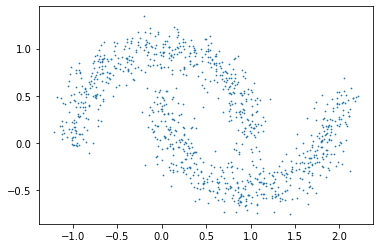

In [402]:
plt.scatter(X[:,0], X[:,1], cmap="grays", s=0.5)

# K-Means
Even when we know there are only 2 clusters in this dataset, we can see that k-means just separates the space into two evenly-sized regions. It's not possible to model the interleaved and odd cluster shapes without performing some heavy pre-processing to project the points into a space where they can be modeled with fixed-sized balls.

In [403]:
from cuml.cluster import KMeans

In [404]:
kmeans_labels_ = KMeans(n_clusters=2).fit_predict(X)

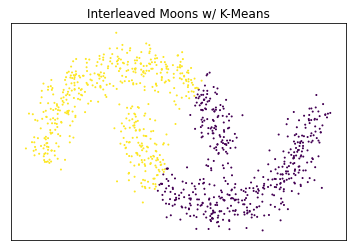

In [405]:
plt.title("Interleaved Moons w/ K-Means")
plt.xticks([])
plt.yticks([])
plt.scatter(X[:,0], X[:,1], c=kmeans_labels_, s=1.0)

## DBSCAN

While this particular example dataset tends to be a great demonstration of how DBSCAN can find clusters of odd shapes and similar densities, the `eps` parameter sets the radius of a ball around each point where points inside the ball are considered part of its neighborhood. This neighborhood is called an epsilon neighborhoods and it can be pretty non-intuitive to tune in practice. In addition, it's assumed that the same `eps` setting applies globally to all the data points. A little bit more intuitive is the `min_samples` parameter, which determines the neighborhood size within the `eps` ball for a point to be considered a `core point`, upon which its neighborhood will be expanded to form a cluster.

In [406]:
from cuml.cluster import DBSCAN

As we can see, the default paramter settings of DBSCAN (and other density-based algorithms) make assumptions about the data that won't often lead to good clustering results. 

In [407]:
dbscan_labels_ = DBSCAN().fit_predict(X)

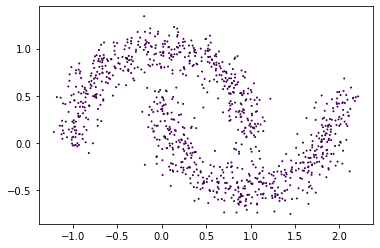

In [408]:
plt.scatter(X[:,0], X[:,1], c=dbscan_labels_, s=1.0)

We can set the `min_samples` parameter to 10, but the amount of noise is too high for this alone to result in good cluster assignments.

In [409]:
dbscan_labels_ = DBSCAN(min_samples=10).fit_predict(X)

In [410]:
import numpy as np
np.unique(dbscan_labels_)

array([0], dtype=int32)

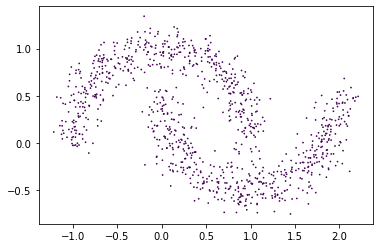

In [411]:
plt.scatter(X[:,0], X[:,1], c=dbscan_labels_, s=0.5)

We can introduce a setting for the `eps` parameter, but it's unclear how to determine a good setting for this value just from this visualization. Setting this value too small can yield too many small clusterings which are not representative of the larger patterns in the data.

In [412]:
dbscan_labels_ = DBSCAN(min_samples=10, eps=0.08).fit_predict(X)
np.unique(dbscan_labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20], dtype=int32)

In [426]:
len(dbscan_labels_[dbscan_labels_==-1]) / X.shape[0]

0.126

Increasing `eps` to 0.1 did the trick and we notice it found the points which surround the dense regions as noise (these will have a label of -1)

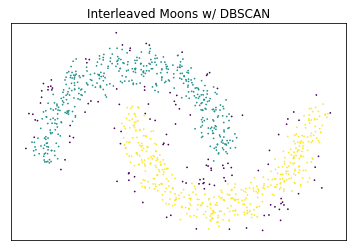

In [413]:
dbscan_labels_ = DBSCAN(min_samples=10, eps=0.1).fit_predict(X)
plt.title("Interleaved Moons w/ DBSCAN")
plt.xticks([])
plt.yticks([])

plt.scatter(X[:,0], X[:,1], c=dbscan_labels_, s=0.5)

## HDBSCAN

HDBSCAN removes the need to specify a global epsilon neighborhood radius around each point (`eps`) and instead uses the `min_points` argument to create a radius to its k-th nearest neighbor, using the radius to push sparser regions further away from each other. Since HDBSCAN is built upon the agglomerative clustering technique single-linkage clustering, each point starts as its own cluster and is merged into a tree, bottom-up, until a single root cluster is reached. A `min_cluster_size` argument allows us to specify a minimum threshold for when clusters in the agglomerated tree should be merged. The dendrogram is cut at varying levels, or selected, using a measure of cluster stability, based on the distances between the points in each cluster and the clusters from which they originated. Clusters which are selected cosume all of their descendent clusters. HDBSCAN provides an additional option `cluster_selection_epsilon` to set the minimum distance threshold from which clusters will be split up into smaller clusters.

In [419]:
from cuml.experimental.cluster import HDBSCAN

In [420]:
labels_ = HDBSCAN(min_samples=10).fit_predict(X)

/datasets/cnolet/conda/envs/cuml_2108_071221/lib/python3.8/site-packages/cuml-21.8.0a0+113.gc9abba1a4-py3.8-linux-x86_64.egg/cuml/internals/api_decorators.py:794: FutureWarning: Pass handle=None, verbose=False, output_type=None as keyword args. From version 21.06, passing these as positional arguments will result in an error
  return func(**kwargs)


In [421]:
np.unique(labels_)

array([-1,  0,  1], dtype=int32)

In [424]:
len(labels_[labels_==-1]) / X.shape[0]

0.096

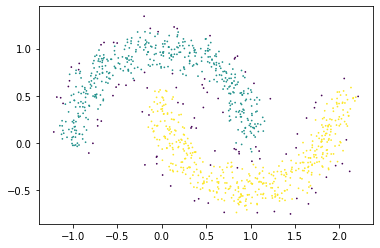

In [417]:
plt.scatter(X[:,0], X[:,1], c=labels_, s=0.5)

Adding the same clustering against the reference Python HDBSCAN implementation

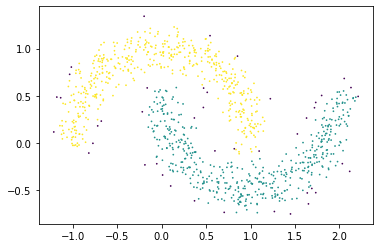

In [418]:
from hdbscan import HDBSCAN as HDBSCANref
labels_ = HDBSCANref(min_samples=25).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=labels_, s=0.5)